In [1]:
import boto3
import sagemaker

In [2]:
sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

In [3]:
bucket = sagemaker_session.default_bucket()
code_location = f's3://{bucket}/xgboost/code'
output_path = f's3://{bucket}/xgboost/output'

### Define hyperparameter

In [4]:
hyperparameters = {
       "scale_pos_weight" : "29",    
        "max_depth": "3",
        "eta": "0.2",
        "objective": "binary:logistic",
        "num_round": "100",
}

### Cluster Specification

In [5]:
instance_count = 1
instance_type = "ml.m5.large"
# instance_type = "local"
max_run = 1*60*60

use_spot_instances = False
if use_spot_instances:
    max_wait = 1*60*60
else:
    max_wait = None

In [6]:
if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
else:
    sagemaker_session = sagemaker.session.Session()

### Define training cluster

In [7]:
from sagemaker.xgboost.estimator import XGBoost

estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    source_dir='src',
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    role=role,
    sagemaker_session=sagemaker_session,
    instance_count=instance_count,
    instance_type=instance_type,
    framework_version="1.3-1",
    max_run=max_run,
    use_spot_instances=use_spot_instances,  # spot instance 활용
    max_wait=max_wait,
)

### Prepare training dataset

In [8]:
data_path=f's3://{bucket}/xgboost/dataset'
!aws s3 sync ./data/dataset/ $data_path

In [9]:
if instance_type in ['local', 'local_gpu']:
    from pathlib import Path
    file_path = f'file://{Path.cwd()}'
    inputs = file_path.split('lab_1_training')[0] + '/data/dataset/'
    
else:
    inputs = data_path
inputs

's3://sagemaker-ap-northeast-2-677146750822/xgboost/dataset'

### Define Experiment

In [10]:
!pip install -U sagemaker-experiments

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [11]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from time import strftime

In [12]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name)
        
def create_trial(experiment_name):
    create_date = strftime("%m%d-%H%M%s")       
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name        

### Start training

In [13]:
experiment_name='xgboost-poc-1'

create_experiment(experiment_name)
job_name = create_trial(experiment_name)

estimator.fit(inputs = {'inputdata': inputs},
                  job_name = job_name,
                  experiment_config={
                      'TrialName': job_name,
                      'TrialComponentDisplayName': job_name,
                  },
                  wait=False)

#estimator.fit(inputs = {'inputdata': inputs},
#                  wait=False)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgboost-poc-1-0918-07321663486375


In [14]:
estimator.logs()

2022-09-18 07:32:56 Starting - Starting the training job...
2022-09-18 07:33:11 Starting - Preparing the instances for trainingProfilerReport-1663486375: InProgress
......
2022-09-18 07:34:27 Downloading - Downloading input data......
2022-09-18 07:35:27 Training - Downloading the training image.....[2022-09-18 07:36:09.744 ip-10-0-180-91.ap-northeast-2.compute.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-09-18:07:36:09:INFO] Imported framework sagemaker_xgboost_container.training
[2022-09-18:07:36:09:INFO] No GPUs detected (normal if no gpus installed)
[2022-09-18:07:36:09:INFO] Invoking user training script.
[2022-09-18:07:36:10:INFO] Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for xgboost-starter-script: filename=xgboost_starter_script-1.0.0-py2.py3-none-any.whl size=43853 s

### Analysis

In [15]:
from sagemaker.analytics import ExperimentAnalytics
import pandas as pd
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 100

In [16]:
trial_component_training_analytics = ExperimentAnalytics(
    sagemaker_session= sagemaker_session,
    experiment_name= experiment_name,
    sort_by="metrics.validation:auc.max",        
    sort_order="Descending",
    metric_names=["validation:auc"]
)

trial_component_training_analytics.dataframe()[['Experiments', 'Trials', 'validation:auc - Min', 'validation:auc - Max',
                                                'validation:auc - Avg', 'validation:auc - StdDev', 'validation:auc - Last', 
                                                'eta', 'max_depth', 'num_round', 'scale_pos_weight']]

,Experiments,Trials,validation:auc - Min,validation:auc - Max,validation:auc - Avg,validation:auc - StdDev,validation:auc - Last,eta,max_depth,num_round,scale_pos_weight
0,[xgboost-poc-1],[xgboost-poc-1-0918-01551663466126],0.821841,0.821841,0.821841,0.0,0.821841,"""0.2""","""3""","""100""","""29"""
1,[xgboost-poc-1],[xgboost-poc-1-0918-07321663486375],0.821841,0.821841,0.821841,0.0,0.821841,"""0.2""","""3""","""100""","""29"""


### Evaluation

In [17]:
from sagemaker.processing import FrameworkProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [18]:
instance_count = 1
instance_type = "ml.m5.large"
# instance_type = 'local'

In [19]:
script_eval = FrameworkProcessor(
    XGBoost,
    framework_version="1.3-1",
    role=role,
    instance_type=instance_type,
    instance_count=instance_count
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.


In [20]:
artifacts_dir = estimator.model_data

In [21]:
s3_test_path = data_path + '/test.csv'
detect_outputpath = f's3://{bucket}/xgboost/processing'

In [22]:
source_dir='src'

if instance_type == 'local':
    from sagemaker.local import LocalSession
    from pathlib import Path

    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    source_dir = f'{Path.cwd()}/src'
    s3_test_path=f'../data/dataset/test.csv'

In [23]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

script_eval.run(
    code="evaluation.py",
    source_dir=source_dir,
    inputs=[ProcessingInput(source=s3_test_path, input_name="test_data", destination="/opt/ml/processing/test"),
            ProcessingInput(source=artifacts_dir, input_name="model_weight", destination="/opt/ml/processing/model")
    ],
    outputs=[
        ProcessingOutput(source="/opt/ml/processing/output", output_name='evaluation', destination=detect_outputpath + "/" + job_name),
    ],
    job_name=job_name,
    experiment_config={
        'TrialName': job_name,
        'TrialComponentDisplayName': job_name,
    },
    wait=False
)

INFO:sagemaker.processing:Uploaded src to s3://sagemaker-ap-northeast-2-677146750822/xgboost-poc-1-0918-07431663487026/source/sourcedir.tar.gz
INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-ap-northeast-2-677146750822/xgboost-poc-1-0918-07431663487026/source/runproc.sh
INFO:sagemaker:Creating processing-job with name xgboost-poc-1-0918-07431663487026



Job Name:  xgboost-poc-1-0918-07431663487026
Inputs:  [{'InputName': 'test_data', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-677146750822/xgboost/dataset/test.csv', 'LocalPath': '/opt/ml/processing/test', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'model_weight', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-677146750822/xgboost/output/xgboost-poc-1-0918-07321663486375/output/model.tar.gz', 'LocalPath': '/opt/ml/processing/model', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-northeast-2-677146750822/xgboost-poc-1-0918-07431663487026/source/sourcedir.tar.gz', 'LocalPath': '/opt/ml/processing/input/code/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionTyp

In [24]:
script_eval.latest_job.wait()

...........................
#############################################
args.model_path: /opt/ml/processing/model/model.tar.gz
args.test_path: /opt/ml/processing/test/test.csv
args.output_evaluation_dir: /opt/ml/processing/output
****** All folder and files under /opt/ml/processing ****** 
('/opt/ml/processing', ['input', 'model', 'test', 'output'], [])
('/opt/ml/processing/input', ['code', 'entrypoint'], [])
('/opt/ml/processing/input/code', ['.ipynb_checkpoints', 'build', 'xgboost_starter_script.egg-info'], ['setup.py', 'setup.cfg', 'xgboost_starter_script.py', 'evaluation.py', 'sourcedir.tar.gz', 'MANIFEST.in'])
('/opt/ml/processing/input/code/.ipynb_checkpoints', [], ['xgboost_starter_script-checkpoint.py'])
('/opt/ml/processing/input/code/build', ['bdist.linux-x86_64', 'lib'], [])
('/opt/ml/processing/input/code/build/bdist.linux-x86_64', [], [])
('/opt/ml/processing/input/code/build/lib', ['.ipynb_checkpoints', 'build', 'xgboost_starter_script.egg-info'], ['setup.py', 'setup.cf

### Check Result

In [25]:
artifacts_dir = estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-ap-northeast-2-677146750822/xgboost/output/xgboost-poc-1-0918-07321663486375/output/
2022-09-18 07:36:41    4.2 KiB model.tar.gz
2022-09-18 07:36:41  188 Bytes output.tar.gz


In [26]:
model_dir = './model'

!rm -rf $model_dir

import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

!aws s3 cp {artifacts_dir}model.tar.gz {model_dir}/model.tar.gz
!tar -xvzf {model_dir}/model.tar.gz -C {model_dir}

download: s3://sagemaker-ap-northeast-2-677146750822/xgboost/output/xgboost-poc-1-0918-07321663486375/output/model.tar.gz to model/model.tar.gz
xgboost-model


In [27]:
!pip install xgboost graphviz

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [28]:
import xgboost as xgb
import matplotlib.pyplot as plt

In [29]:
model = xgb.XGBClassifier()
model.load_model("./model/xgboost-model")

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/xgboost/sklearn.py:741: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn(


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

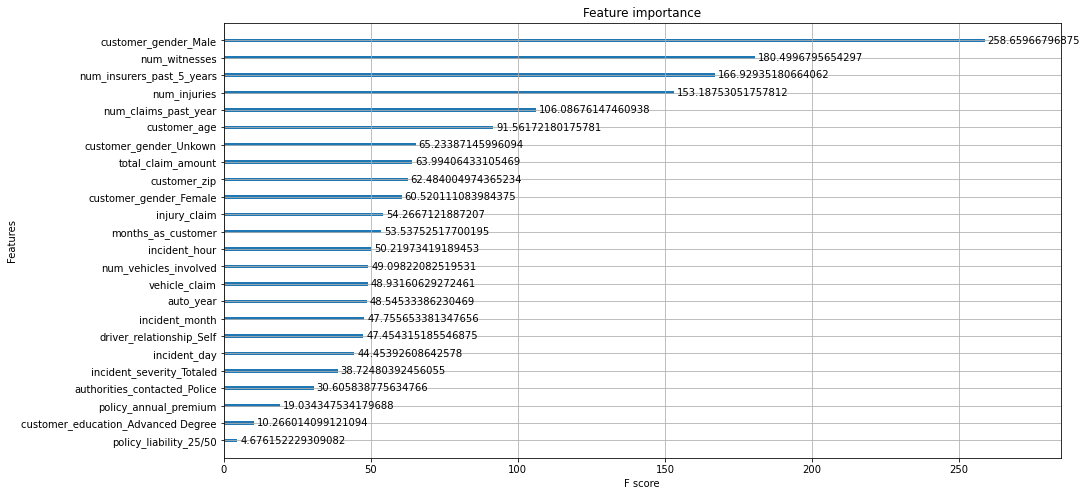

In [31]:
test_prep_df = pd.read_csv('./data/dataset/test.csv')
x_test = test_prep_df.drop('fraud', axis=1)
feature_data = xgb.DMatrix(x_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types
fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain')

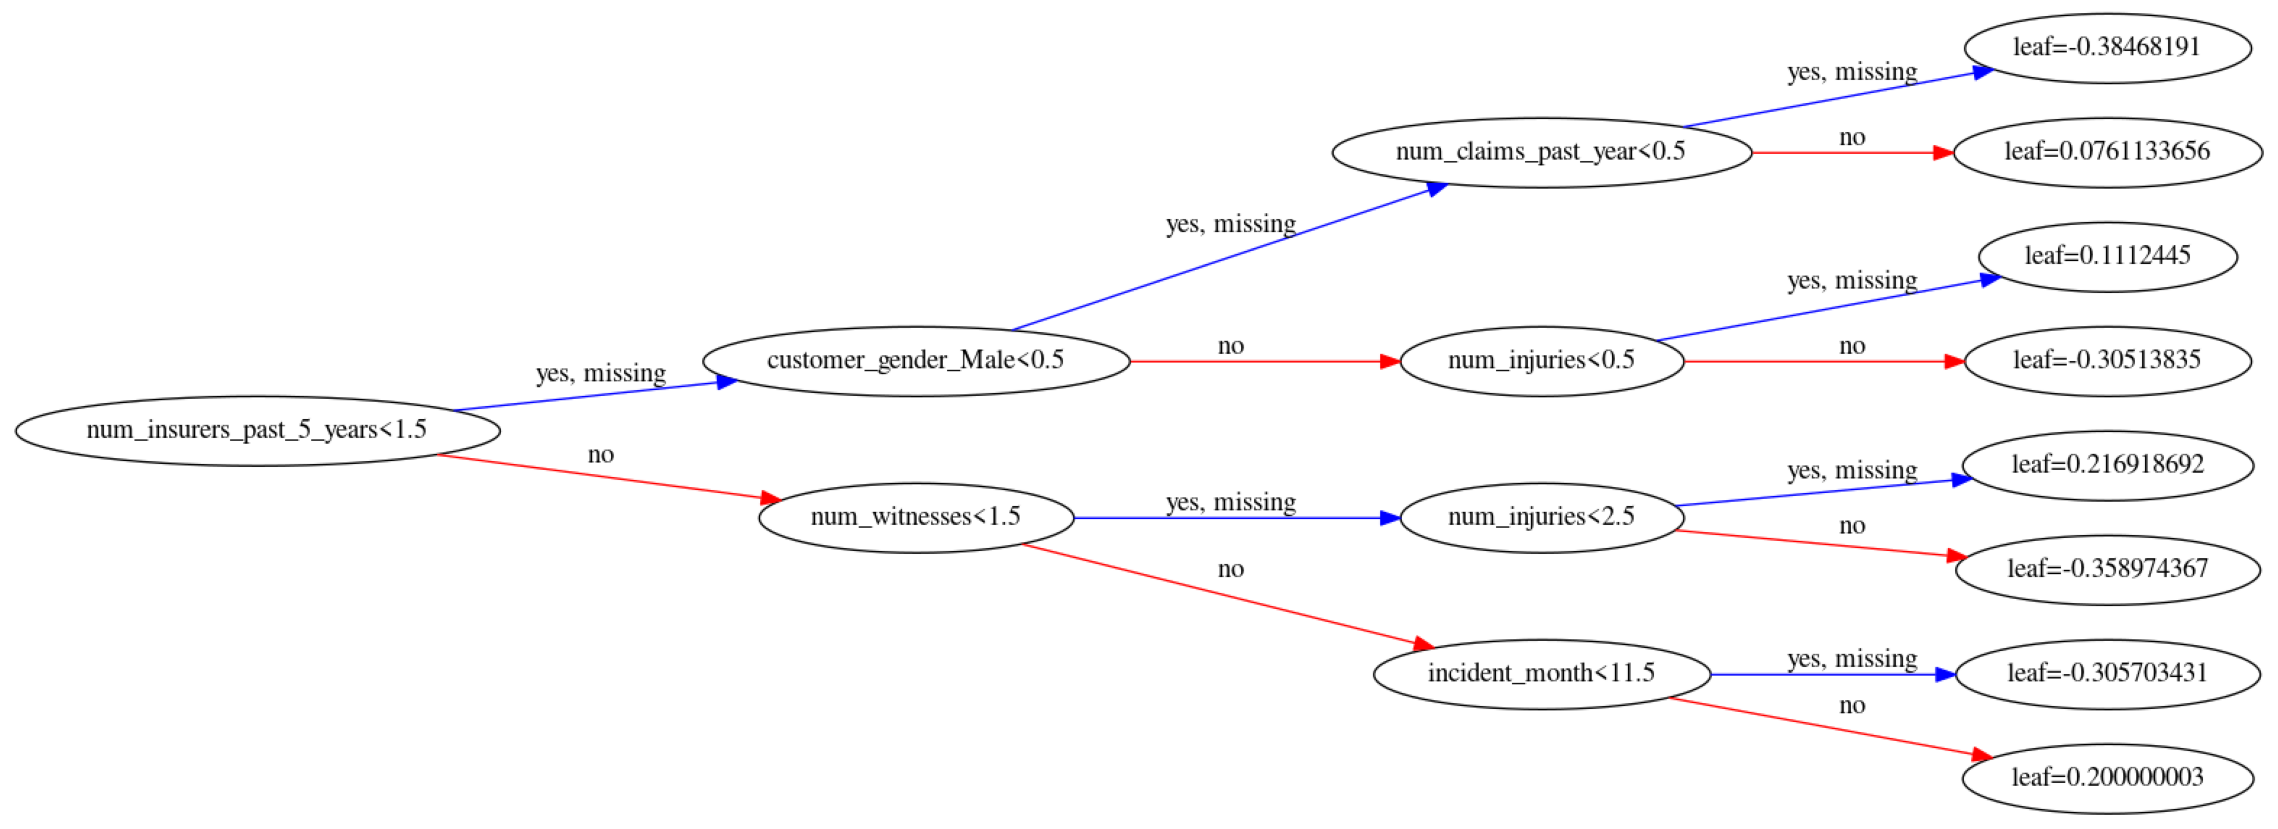

In [32]:
xgb.plot_tree(model, num_trees=0, rankdir='LR')

fig = plt.gcf()
fig.set_size_inches(50, 15)
plt.show()